In [150]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision


torch.manual_seed(666)


weird_chips = ["bcwo", "bcww", "gukp", "igyf"]


def get_chip(path):
    return path.split('/')[-1].replace('.tif', '')


class CloudDataset(Dataset):
    def __init__(self, root_dir, sub_dir):
        self.data_dir = f'{root_dir}/{sub_dir}'
        
        image_paths = glob.glob(f'{self.data_dir}/source/*.tif')
        image_paths = [p for p in image_paths if get_chip(p) not in weird_chips]
        
        label_paths = glob.glob(f'{self.data_dir}/labels/*.tif')
        label_paths = [p for p in label_paths if get_chip(p) not in weird_chips]

        f_image_paths = [pi for pi in image_paths for pl in label_paths if pi.split('/')[-1] == pl.split('/')[-1]]
        f_label_paths = [pl for pl in label_paths for pi in image_paths if pl.split('/')[-1] == pi.split('/')[-1]]

        f_image_paths = sorted(f_image_paths, key=lambda x: x.split('/')[-1])
        f_label_paths = sorted(f_label_paths, key=lambda x: x.split('/')[-1])

        self.image_paths = f_image_paths
        self.label_paths = f_label_paths
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
                
        image_path = self.image_paths[index]
        label_path = self.label_paths[index]
        chip_ip = image_path.split('/')[-1].replace('.tif', '')
        
        with rasterio.open(image_path) as src:
            image = src.read()
            image = torch.from_numpy(image)

        with rasterio.open(label_path) as src:
            label = src.read()
            label = torch.from_numpy(label).long()
            
        return image, label
    

re_cloud_dir = "./data/radiantEarth/clouds"

train_dataset = CloudDataset(root_dir=re_cloud_dir, sub_dir='train')
train_dataloader = DataLoader(train_dataset, batch_size=8, num_workers=0, shuffle=True)

test_dataset = CloudDataset(root_dir=re_cloud_dir, sub_dir='test')
test_dataloader = DataLoader(test_dataset, batch_size=8, num_workers=0, shuffle=True)


In [151]:

ACTIVATION = None
ENCODER = 'resnet18' # resnet18, resnet50, vgg16
LOSS = 'dice' # dice, cross_entropy

model = smp.UnetPlusPlus(
    encoder_name=ENCODER,
    encoder_depth=5, 
    encoder_weights='imagenet', 
    decoder_use_batchnorm=True, 
    decoder_channels=(256, 128, 64, 32, 16), 
    decoder_attention_type=None,
    in_channels=4,
    classes=3,
    activation=ACTIVATION
)


if LOSS == 'dice':
    loss = smp.losses.DiceLoss(mode="multiclass")
    loss.__name__ = 'Dice_loss'
    
elif LOSS == 'cross_entropy':
    loss = smp.losses.SoftCrossEntropyLoss(smooth_factor=0.01)
    loss.__name__ = 'SoftCE_loss'
    
else:
    raise ValueError("unknown loss")


optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001) # 0.1

metrics = []

In [152]:

train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=loss,
    metrics= metrics,
    optimizer=optimizer,
    verbose=True,
)

test_epoch = smp_utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    verbose=True,
)


NUM_EPOCHS = 2

model_path =  f'./best_{ENCODER}_{LOSS}_cloud_model.pth'

# 40: 0.2436, 80: 0.1866, 200: 0.1553, 800: 

for i in range(0, NUM_EPOCHS):
    train_logs = train_epoch.run(train_dataloader)
    test_logs = test_epoch.run(test_dataloader)
    torch.save(model, model_path)
    
print('done')

train:   5%|▌         | 5/100 [00:47<15:09,  9.58s/it, Dice_loss - 0.1303]


KeyboardInterrupt: 

./data/radiantEarth/clouds/test/source/bcxb.tif
./data/radiantEarth/clouds/test/source/bcxq.tif
./data/radiantEarth/clouds/test/source/bczg.tif


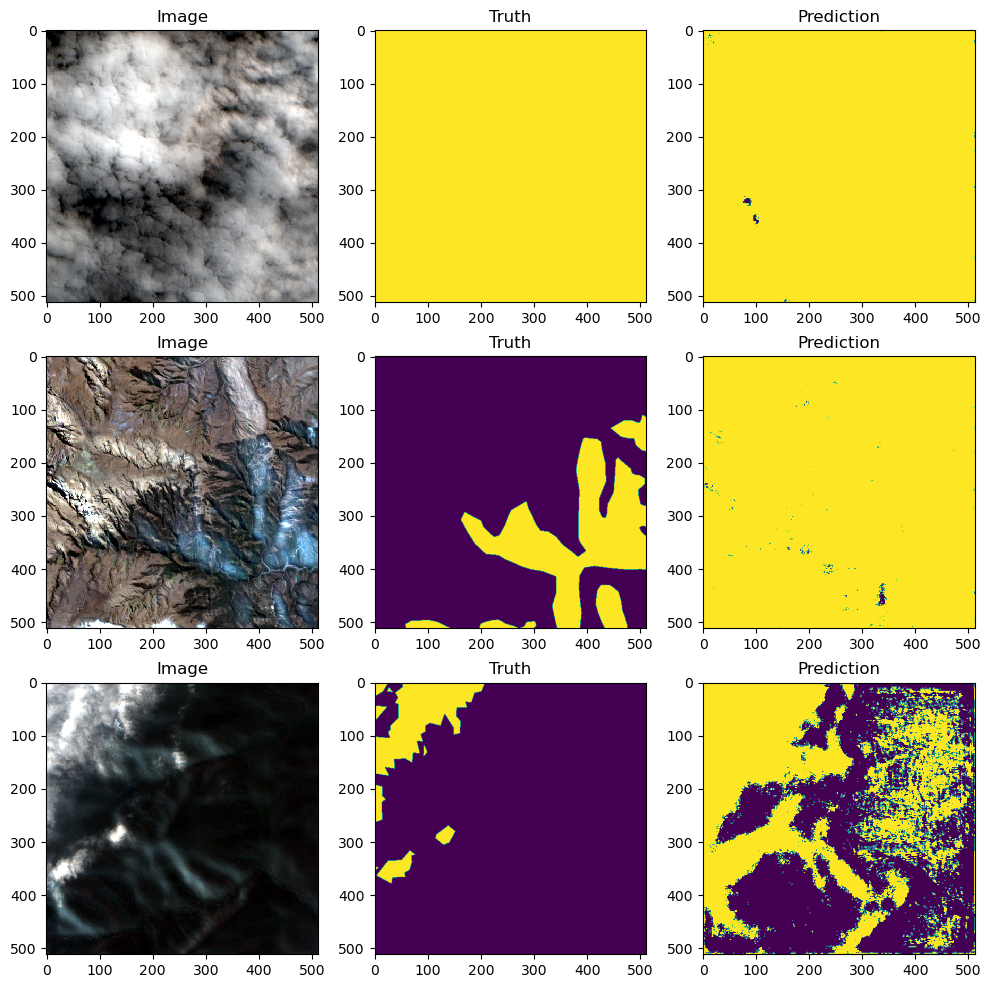

In [147]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn


from common.utilities.visualization import plot_bands


count = 3

fig, rows = plt.subplots(count, 3, figsize=(12, 12))
if rows.ndim == 1:
    rows = np.expand_dims(rows, 0)
  

best_model = torch.load(model_path)


for i in range(count):
    
    offset = 0
                
    row = rows[i]    
    image, labels = test_dataset[i + offset]    
    image_path = test_dataset.image_paths[i + offset]
    print(image_path)
    
    image = np.expand_dims(image, 0) 
    image = torch.tensor(image)

    prediction = best_model.predict(image)    
    softmax = nn.Softmax(dim=1)
    probabilities = softmax(prediction) 
        
    prediction = torch.argmax(probabilities, dim=1).squeeze(1)
    prediction = (prediction.squeeze().cpu().numpy().round())
    #prediction = np.ma.array(prediction, mask=(prediction==0))
    
    labels = labels.squeeze().numpy()
    labels = np.ma.array(labels, mask=(labels==2))

    image = image.cpu().numpy().squeeze(0)
    plot_bands(image, bands=[2, 1, 0], ax=row[0], transpose=True)
    row[0].set_title('Image')
    
    row[1].imshow(labels, vmin=0, vmax=1)
    row[1].set_title('Truth')
    
    row[2].imshow(prediction, vmin=0, vmax=1)
    row[2].set_title('Prediction')
    
    

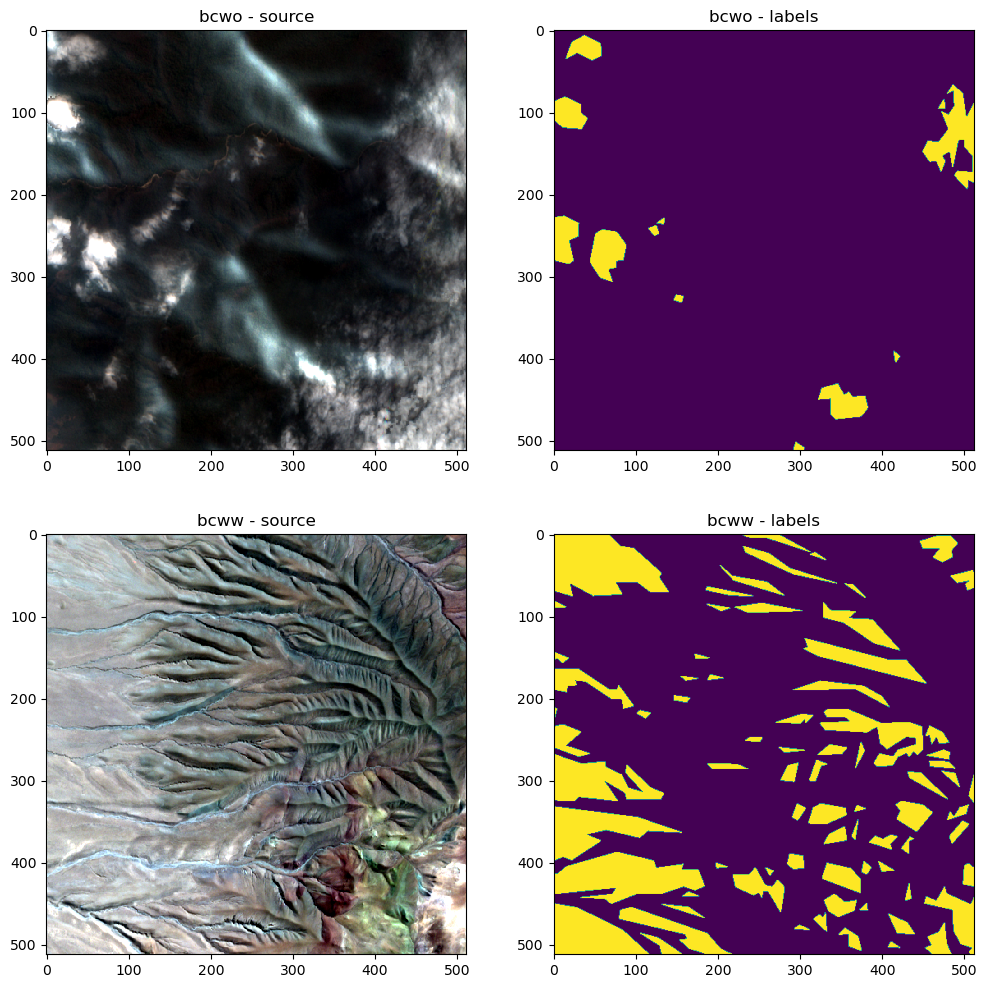

In [106]:


weird_chips = ["bcwo", "bcww", "gukp", "igyf"]

fig, rows = plt.subplots(len(chips), 2, figsize=(12, 12))

for i, chip_id in enumerate(weird_chips):

    image_path = f"./data/radiantEarth/clouds/test/source/{chip_id}.tif"
    label_path = f"./data/radiantEarth/clouds/test/labels/{chip_id}.tif"

    with rasterio.open(image_path) as src:
        image_data = src.read()

    with rasterio.open(label_path) as src:
        label_data = src.read(1)

    row = rows[i]
        
    plot_bands(image_data, bands=[2, 1, 0], ax=row[0], transpose=True)
    row[0].set_title(f'{chip_id} - source')
    
    row[1].imshow(label_data)
    row[1].set_title(f'{chip_id} - labels')
